In [1]:
import numpy as np
import pandas as pd
import matplotlib.pyplot as plt
from keras.layers import BatchNormalization
from IPython.display import display
import datetime
import os

from sklearn.preprocessing import OneHotEncoder
from sklearn.compose import ColumnTransformer

In [65]:
data=pd.read_csv(r'DSL-StrongPasswordData.csv')

data.info()
display(data.head())

<class 'pandas.core.frame.DataFrame'>
RangeIndex: 20400 entries, 0 to 20399
Data columns (total 34 columns):
 #   Column           Non-Null Count  Dtype  
---  ------           --------------  -----  
 0   subject          20400 non-null  object 
 1   sessionIndex     20400 non-null  int64  
 2   rep              20400 non-null  int64  
 3   H.period         20400 non-null  float64
 4   DD.period.t      20400 non-null  float64
 5   UD.period.t      20400 non-null  float64
 6   H.t              20400 non-null  float64
 7   DD.t.i           20400 non-null  float64
 8   UD.t.i           20400 non-null  float64
 9   H.i              20400 non-null  float64
 10  DD.i.e           20400 non-null  float64
 11  UD.i.e           20400 non-null  float64
 12  H.e              20400 non-null  float64
 13  DD.e.five        20400 non-null  float64
 14  UD.e.five        20400 non-null  float64
 15  H.five           20400 non-null  float64
 16  DD.five.Shift.r  20400 non-null  float64
 17  UD.five.Shif

,subject,sessionIndex,rep,H.period,DD.period.t,UD.period.t,H.t,DD.t.i,UD.t.i,H.i,DD.i.e,UD.i.e,H.e,DD.e.five,UD.e.five,H.five,DD.five.Shift.r,UD.five.Shift.r,H.Shift.r,DD.Shift.r.o,UD.Shift.r.o,H.o,DD.o.a,UD.o.a,H.a,DD.a.n,UD.a.n,H.n,DD.n.l,UD.n.l,H.l,DD.l.Return,UD.l.Return,H.Return
0,s002,1,1,0.1491,0.3979,0.2488,0.1069,0.1674,0.0605,0.1169,0.2212,0.1043,0.1417,1.1885,1.0468,0.1146,1.6055,1.4909,0.1067,0.7590,0.6523,0.1016,0.2136,0.1120,0.1349,0.1484,0.0135,0.0932,0.3515,0.2583,0.1338,0.3509,0.2171,0.0742
1,s002,1,2,0.1111,0.3451,0.2340,0.0694,0.1283,0.0589,0.0908,0.1357,0.0449,0.0829,1.1970,1.1141,0.0689,0.7822,0.7133,0.1570,0.7877,0.6307,0.1066,0.1684,0.0618,0.1412,0.2558,0.1146,0.1146,0.2642,0.1496,0.0839,0.2756,0.1917,0.0747
2,s002,1,3,0.1328,0.2072,0.0744,0.0731,0.1291,0.0560,0.0821,0.1542,0.0721,0.0808,1.0408,0.9600,0.0892,0.6203,0.5311,0.1454,0.7195,0.5741,0.1365,0.2931,0.1566,0.1621,0.2332,0.0711,0.1172,0.2705,0.1533,0.1085,0.2847,0.1762,0.0945
3,s002,1,4,0.1291,0.2515,0.1224,0.1059,0.2495,0.1436,0.1040,0.2038,0.0998,0.0900,1.0556,0.9656,0.0913,1.2564,1.1651,0.1454,0.7550,0.6096,0.0956,0.1530,0.0574,0.1457,0.1629,0.0172,0.0866,0.2341,0.1475,0.0845,0.3232,0.2387,0.0813
4,s002,1,5,0.1249,0.2317,0.1068,0.0895,0.1676,0.0781,0.0903,0.1589,0.0686,0.0805,0.8629,0.7824,0.0742,0.8955,0.8213,0.1243,0.7632,0.6389,0.0430,0.1975,0.1545,0.1312,0.1582,0.0270,0.0884,0.2517,0.1633,0.0903,0.2517,0.1614,0.0818


In [66]:

data.drop(columns=['sessionIndex','rep'],axis=1,inplace=True)
visual_data=data


ct=ColumnTransformer(transformers=[('encoder',OneHotEncoder(),[0])],remainder='passthrough')
unique_cols=data['subject'].nunique()

data=np.array(ct.fit_transform(data))
X=data[:,unique_cols:]
y=data[:,:unique_cols]
print(y.shape)


#splitting the dataset into train and test set
from sklearn.model_selection import train_test_split
X_train, X_test, y_train, y_test = train_test_split(X, y, test_size=0.1, random_state=1)

#applying feature scaling
from sklearn.preprocessing import StandardScaler
sc=StandardScaler()
X_train=sc.fit_transform(X_train)

X_test=sc.transform(X_test)



(20400, 51)


In [67]:
import tensorflow as tf


model = tf.keras.models.Sequential()

#cnn.add(tf.keras.layers.Flatten())

model.add(tf.keras.layers.Dense(units=256,activation='relu'))
model.add(BatchNormalization())

model.add(tf.keras.layers.Dense(units=512,activation='relu'))
model.add(BatchNormalization())

model.add(tf.keras.layers.Dense(units=1024,activation='relu'))
model.add(BatchNormalization())

model.add(tf.keras.layers.Dense(units=512,activation='relu'))

model.add(tf.keras.layers.Dense(units=unique_cols,activation='sigmoid'))

model.compile(optimizer='adam',loss='binary_crossentropy',metrics=['accuracy'])

In [69]:
batch_size = 32
epochs=50

logs_base_dir = "./logs"
logdir = os.path.join(logs_base_dir, datetime.datetime.now().strftime("%Y%m%d-%H%M%S"))
tensorboard_callback = tf.keras.callbacks.TensorBoard(logdir)


hist = model.fit(X_train, y_train, epochs = epochs, batch_size=batch_size, validation_split = 0.1, verbose = 1)

Epoch 1/50
517/517 [==============================] - 4s 5ms/step - loss: 0.0723 - accuracy: 0.6295 - val_loss: 0.0194 - val_accuracy: 0.8475
Epoch 2/50
517/517 [==============================] - 2s 4ms/step - loss: 0.0178 - accuracy: 0.8552 - val_loss: 0.0158 - val_accuracy: 0.8791
Epoch 3/50
517/517 [==============================] - 2s 4ms/step - loss: 0.0130 - accuracy: 0.8947 - val_loss: 0.0137 - val_accuracy: 0.8960
Epoch 4/50
517/517 [==============================] - 2s 5ms/step - loss: 0.0109 - accuracy: 0.9170 - val_loss: 0.0112 - val_accuracy: 0.9161
Epoch 5/50
517/517 [==============================] - 3s 5ms/step - loss: 0.0089 - accuracy: 0.9310 - val_loss: 0.0133 - val_accuracy: 0.8992
Epoch 6/50
517/517 [==============================] - 2s 4ms/step - loss: 0.0082 - accuracy: 0.9378 - val_loss: 0.0115 - val_accuracy: 0.9112
Epoch 7/50
517/517 [==============================] - 2s 4ms/step - loss: 0.0072 - accuracy: 0.9472 - val_loss: 0.0110 - val_accuracy: 0.9199
Epoch 

In [70]:
model.summary()

Model: "sequential_7"
_________________________________________________________________
Layer (type)                 Output Shape              Param #   
dense_35 (Dense)             (None, 256)               8192      
_________________________________________________________________
batch_normalization_21 (Batc (None, 256)               1024      
_________________________________________________________________
dense_36 (Dense)             (None, 512)               131584    
_________________________________________________________________
batch_normalization_22 (Batc (None, 512)               2048      
_________________________________________________________________
dense_37 (Dense)             (None, 1024)              525312    
_________________________________________________________________
batch_normalization_23 (Batc (None, 1024)              4096      
_________________________________________________________________
dense_38 (Dense)             (None, 512)              

In [71]:
model.save('bestModel.h5')
model.load_weights('bestModel.h5')

In [72]:
#print(hist.history['loss'])

score,acc = model.evaluate(X_test, y_test, verbose = 1, batch_size = batch_size)
print("score: "+str(score)+" accuracy: "+str(acc))

64/64 [==============================] - 0s 2ms/step - loss: 0.0143 - accuracy: 0.9382
score: 0.014274440705776215 accuracy: 0.9382352828979492


In [73]:
train_loss = hist.history['loss']
val_loss   = hist.history['val_loss']
acc = hist.history['accuracy']
val_acc = hist.history['val_accuracy']

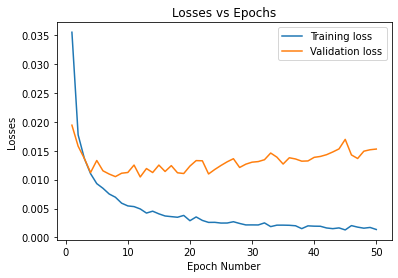

In [74]:
plt.plot(range(1,epochs+1),train_loss)
plt.plot(range(1,epochs+1),val_loss)
plt.title('Losses vs Epochs')
plt.xlabel('Epoch Number')
plt.ylabel('Losses')
plt.legend(["Training loss", "Validation loss"])

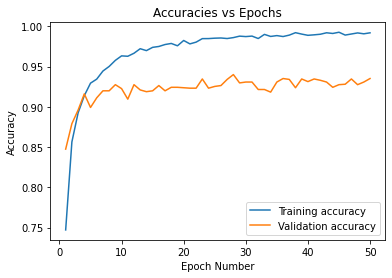

In [75]:
plt.plot(range(1,epochs+1),acc)
plt.plot(range(1,epochs+1),val_acc)
plt.title('Accuracies vs Epochs')
plt.xlabel('Epoch Number')
plt.ylabel('Accuracy')
plt.legend(["Training accuracy", "Validation accuracy"])

In [76]:
y_pred=model.predict(X_test)
'''as the softmax outputs probability of each class there is need for conversion from  probability to 0s and 1s
where the class corresponding to highest probability will be set to 1 and the rest to 0s.
y_pred is an array of probabilities where y_pred_binary is an array of 0s and 1s.'''


y_pred_binary=np.zeros(shape=y_pred.shape)
examples=y_pred.shape[0]
print(examples)
for i in range(examples):
    index=np.argmax(y_pred[i])
    y_pred_binary[i][index]=1


2040


In [77]:
data

array([[1.    , 0.    , 0.    , ..., 0.3509, 0.2171, 0.0742],
       [1.    , 0.    , 0.    , ..., 0.2756, 0.1917, 0.0747],
       [1.    , 0.    , 0.    , ..., 0.2847, 0.1762, 0.0945],
       ...,
       [0.    , 0.    , 0.    , ..., 0.2017, 0.0983, 0.0905],
       [0.    , 0.    , 0.    , ..., 0.1917, 0.0938, 0.0931],
       [0.    , 0.    , 0.    , ..., 0.1993, 0.1186, 0.1018]])

In [ ]:
# Load the extension and start TensorBoard
%load_ext tensorboard
%tensorboard --logdir logs